# Entry G10b notebook: Bimodal Model Global Metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('once')

from neo4j import GraphDatabase

## Connect to the database

The title of the post should give away which version of the database we're using: the bimodal version. See [Entry G6b notebook](https://github.com/julielinx/datascience_diaries/blob/master/graph/06_7_8a_nb_bimodal_global_metrics.ipynb) if you need more detailed instructions on connecting to the database.

#### 1. Open Neo4j and start the unimodal graph

#### 2. Connect the Jupyter notebook to the database

In [2]:
uri = "bolt://localhost:7687"

driver = GraphDatabase.driver(uri, auth=('neo4j', 'password'))
session = driver.session()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 3. Start running queries

## Degree Count

This is the same as the relationship count that I ran in the [Entry G6b notebook](https://github.com/julielinx/datascience_diaries/blob/master/graph/06_7_8a_nb_bimodal_global_metrics.ipynb). I'm including it here as a reminder of how many relationships we have in the graph.

In [3]:
session.run('''MATCH ()-[r]->()
RETURN count(r) as count''').data()

[{'count': 96104}]

## Degree Summary Statistics

In [4]:
session.run('''MATCH (c1)-[]-(c2)
WITH c1, count(distinct c2) as degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)) as degree_avg,
round(stDev(degree)) as degree_stdev
''').data()

[{'degree_min': 1,
  'degree_max': 1577,
  'degree_avg': 10.0,
  'degree_stdev': 35.0}]

The pattern match `(c1-[]-(c2)` means that we'll only return nodes that have some connection, which means that isolated nodes won't be returned.

To get around this, we can use the `apoc.node.degree` function. The only difference in the descriptive statistics is that isolated nodes are the minimum (0) and by including those 18 claims, our standard deviation is very slightly lower.

In [5]:
session.run('''MATCH (n)
RETURN min(apoc.node.degree(n)) as degree_min,
max(apoc.node.degree(n)) as degree_max,
round(avg(apoc.node.degree(n))*100)/100 as degree_avg,
round(stdev(apoc.node.degree(n))*100)/100 as degree_stdev''').data()

[{'degree_min': 1,
  'degree_max': 1577,
  'degree_avg': 10.07,
  'degree_stdev': 34.99}]

Be sure to specify the orientation when using the `gds.alpha.degree.stream()` function. It defaults to `NATURAL` which are outgoing relationships from the source node. Since my graph is undrected, I used `UNDIRECTED`. The third option is `REVERSE` which uses incoming relationships to the source node.

In [8]:
session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()

[{'degree_min': 1.0,
  'degree_max': 1577.0,
  'degree_avg': 10.07,
  'degree_stdev': 34.99}]

In [43]:
pd.DataFrame(session.run("call apoc.meta.stats() YIELD labels").value())

,Hero,Comic
0,6439,12651


In [9]:
session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'REVERSE'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()

[{'degree_min': 0.0,
  'degree_max': 111.0,
  'degree_avg': 5.03,
  'degree_stdev': 6.35}]

In [21]:
session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'NATURAL'
  }}
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS degree
RETURN min(degree) as degree_min,
max(degree) as degree_max,
round(avg(degree)*100)/100 as degree_avg,
round(stdev(degree)*100)/100 as degree_stdev''').data()

[{'degree_min': 0.0,
  'degree_max': 1577.0,
  'degree_avg': 5.03,
  'degree_stdev': 35.14}]

## Degree Distribution

In [33]:
degree_df = pd.DataFrame(session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: ['Hero', 'Comic'],
  relationshipProjection: {
  APPEARS_IN: {
  type: 'APPEARS_IN',
  orientation:'UNDIRECTED'
  }}
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score AS degree, labels(gds.util.asNode(nodeId))[0] as type
''').values(), columns=['hero', 'degree', 'type'])
degree_df.head()

,hero,degree,type
0,24-HOUR MAN/EMMANUEL,1.0,Hero
1,AA2 35,6.0,Comic
2,3-D MAN/CHARLES CHAN,9.0,Hero
3,AVF 4,11.0,Comic
4,AVF 5,11.0,Comic


//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
//anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


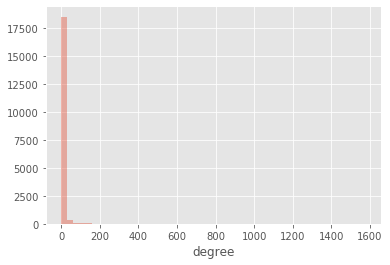

In [17]:
sns.distplot(degree_df['degree'], kde=False)

//anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


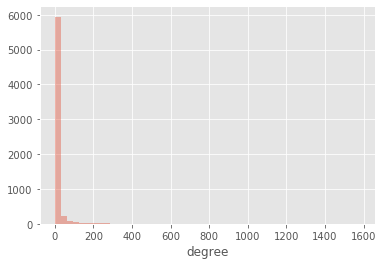

In [35]:
sns.distplot(degree_df.loc[degree_df['type']=='Hero', 'degree'], kde=False)

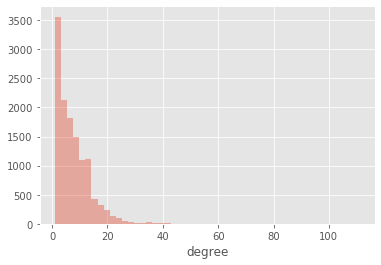

In [36]:
sns.distplot(degree_df.loc[degree_df['type']=='Comic', 'degree'], kde=False)

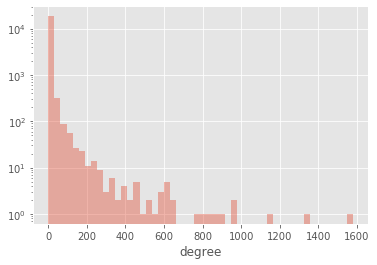

In [18]:
log_degree_plt = sns.distplot(degree_df['degree'], kde=False)
log_degree_plt.set_yscale('log')
plt.show()

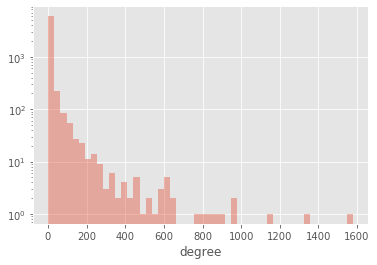

In [37]:
log_degree_plt = sns.distplot(degree_df.loc[degree_df['type']=='Hero', 'degree'], kde=False)
log_degree_plt.set_yscale('log')
plt.show()

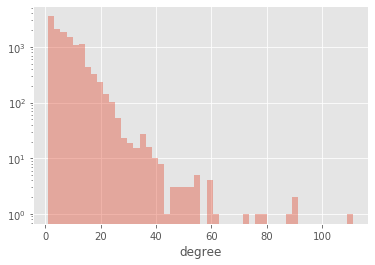

In [38]:
log_degree_plt = sns.distplot(degree_df.loc[degree_df['type']=='Comic', 'degree'], kde=False)
log_degree_plt.set_yscale('log')
plt.show()

## Weighted Degree Count

In the bimodal model of this data there is only one connection between a comic and a hero. As such there is no weight on any of the relationships. Weight is only added if there are multiple relationships between two nodes or to indicate stronger/weaker relationships between the nodes. 